# Ensamble

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:

   - In ***averaging methods***, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

    Examples: 
     - Bagging methods, 
     - Forests of randomized trees, ...

   - By contrast, in **boosting methods**, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

    Examples: 
     - AdaBoost, 
     - Gradient Tree Boosting, ...



In [10]:
%matplotlib inline

------------------

### 1. Single estimator versus bagging: bias-variance decomposition ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

--------------------

This example illustrates and compares the bias-variance decomposition of the
expected mean squared error of a single estimator against a bagging ensemble.

In regression, the expected mean squared error of an estimator can be
decomposed in terms of bias, variance and noise. On average over datasets of
the regression problem, the bias term measures the average amount by which the
predictions of the estimator differ from the predictions of the best possible
estimator for the problem (i.e., the Bayes model). The variance term measures
the variability of the predictions of the estimator when fit over different
instances LS of the problem. Finally, the noise measures the irreducible part
of the error which is due the variability in the data.

The upper left figure illustrates the predictions (in dark red) of a single
decision tree trained over a random dataset LS (the blue dots) of a toy 1d
regression problem. It also illustrates the predictions (in light red) of other
single decision trees trained over other (and different) randomly drawn
instances LS of the problem. Intuitively, the variance term here corresponds to
the width of the beam of predictions (in light red) of the individual
estimators. The larger the variance, the more sensitive are the predictions for
`x` to small changes in the training set. The bias term corresponds to the
difference between the average prediction of the estimator (in cyan) and the
best possible model (in dark blue). On this problem, we can thus observe that
the bias is quite low (both the cyan and the blue curves are close to each
other) while the variance is large (the red beam is rather wide).

The lower left figure plots the pointwise decomposition of the expected mean
squared error of a single decision tree. It confirms that the bias term (in
blue) is low while the variance is large (in green). It also illustrates the
noise part of the error which, as expected, appears to be constant and around
`0.01`.

The right figures correspond to the same plots but using instead a bagging
ensemble of decision trees. In both figures, we can observe that the bias term
is larger than in the previous case. In the upper right figure, the difference
between the average prediction (in cyan) and the best possible model is larger
(e.g., notice the offset around `x=2`). In the lower right figure, the bias
curve is also slightly higher than in the lower left figure. In terms of
variance however, the beam of predictions is narrower, which suggests that the
variance is lower. Indeed, as the lower right figure confirms, the variance
term (in green) is lower than for single decision trees. Overall, the bias-
variance decomposition is therefore no longer the same. The tradeoff is better
for bagging: averaging several decision trees fit on bootstrap copies of the
dataset slightly increases the bias term but allows for a larger reduction of
the variance, which results in a lower overall mean squared error (compare the
red curves int the lower figures). The script output also confirms this
intuition. The total error of the bagging ensemble is lower than the total
error of a single decision tree, and this difference indeed mainly stems from a
reduced variance.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

 - Setting Parameters

In [3]:
# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

Change this for exploring the bias-variance decomposition of other
estimators. This should work well for estimators with high variance (e.g.,
decision trees or KNN), but poorly for estimators with low variance (e.g.,
linear models).

In [4]:
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

 ### Data

In [7]:
# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


### Partition

In [8]:
X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

 ### Plot

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


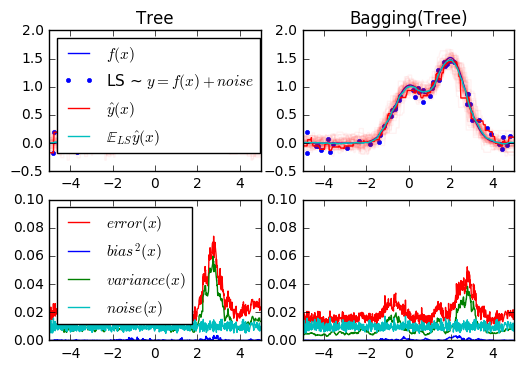

In [11]:
# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

plt.show()


----------------

### 2. OOB Errors for Random Forests ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

-----------------

The ``RandomForestClassifier`` is trained using *bootstrap aggregation*, where each new tree is fit from a bootstrap sample of the training observations

$z_i = (x_i, y_i)$.

The **out-of-bag** (OOB) error is the average error for
each $z_i$ calculated using predictions from the trees that do not
contain $z_i$ in their respective bootstrap sample. This allows the
``RandomForestClassifier`` to be fit and validated whilst being trained 

The example below demonstrates how the OOB error can be measured at the
addition of each new tree during training. The resulting plot allows a
practitioner to approximate a suitable value of ``n_estimators`` at which the error stabilizes.

In [18]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


 #### Data Set

In [19]:
RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

#### warm_start

- NOTE: Setting the `warm_start` construction parameter to `True` disables
support for paralellised ensembles but is necessary for tracking the OOB
error trajectory during training.

In [20]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

* Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.

In [21]:
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

In [22]:
# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))



 #### Plot

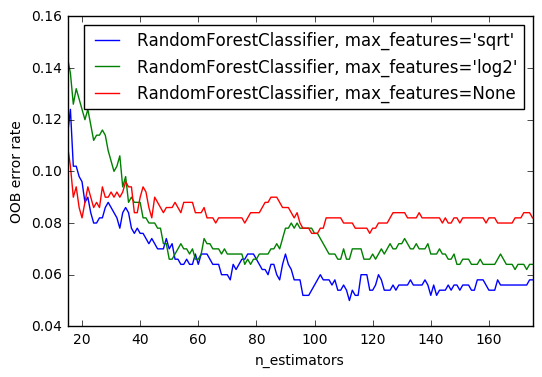

In [23]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()


------------------

### 3. Feature transformations with ensembles of trees ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

------------------

Transform your features into a higher dimensional, sparse space. Then
train a linear model on these features.

First fit an ensemble of trees (totally random trees, a random
forest, or gradient boosted trees) on the training set. Then each leaf
of each tree in the ensemble is assigned a fixed arbitrary feature
index in a new feature space. These leaf indices are then encoded in a
one-hot fashion.

Each sample goes through the decisions of each tree of the ensemble
and ends up in one leaf per tree. The sample is encoded by setting
feature values for these leaves to 1 and the other feature values to 0.

The resulting transformer has then learned a supervised, sparse,
high-dimensional categorical embedding of the data.

In [26]:
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt

#======== models =====================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
#======= data ==================================
from sklearn.datasets import make_classification

 #### Data

In [27]:
n_estimator = 10
X, y = make_classification(n_samples=80000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

It is important to train the ensemble of trees on a different subset
of the training data than the linear regression model to avoid
overfitting, in particular if the total number of leaves is
similar to the number of training samples


In [28]:
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)


 - Unsupervised transformation

In [29]:
# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
	random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

 #### Model

In [30]:
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)


# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)


# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

 - Plot-1

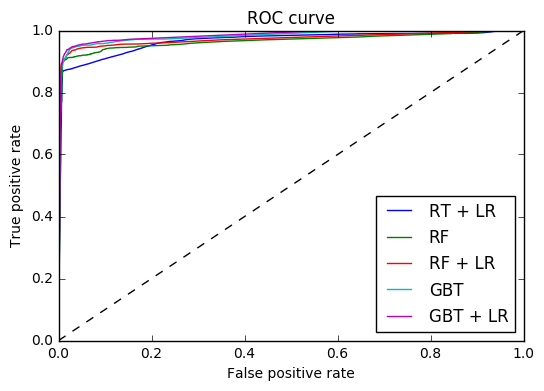

In [31]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

 - Plot-2

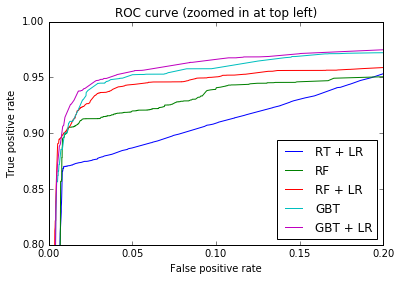

In [20]:
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

-----------

### 4. Pixel importances with a parallel forest of trees ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

--------------

This example shows the use of forests of trees to evaluate the importance
of the pixels in an image classification task (faces). The hotter the pixel,
the more important.

The code below also illustrates how the construction and the computation
of the predictions can be parallelized within multiple jobs.

In [25]:
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesClassifier

 #### Data

In [26]:
# Number of cores to use to perform parallel fitting of the forest model
n_jobs = 1

# Load the faces dataset
data = fetch_olivetti_faces()
X = data.images.reshape((len(data.images), -1))
y = data.target

mask = y < 5  # Limit to 5 classes
X = X[mask]
y = y[mask]

- Perform parallel fitting of the forest model

In [27]:
# Build a forest and compute the pixel importances
print("Fitting ExtraTreesClassifier on faces data with %d cores..." % n_jobs)
t0 = time()
forest = ExtraTreesClassifier(n_estimators=1000,
                              max_features=128,
                              n_jobs=n_jobs,
                              random_state=0)

forest.fit(X, y)
print("done in %0.3fs" % (time() - t0))
importances = forest.feature_importances_
importances = importances.reshape(data.images[0].shape)

Fitting ExtraTreesClassifier on faces data with 1 cores...
done in 2.155s


 ##### Plot

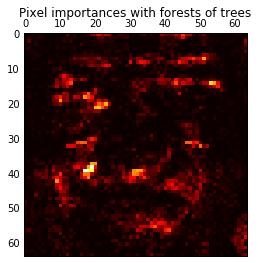

In [28]:
# Plot pixel importances
plt.matshow(importances, cmap=plt.cm.hot)
plt.title("Pixel importances with forests of trees")
plt.show()

-----------------

### 5. Feature importances with forests of trees ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

-----------------

This examples shows the use of forests of trees to evaluate the importance of
features on an artificial classification task. The red bars are the feature
importances of the forest, along with their inter-trees variability.

As expected, the plot suggests that 3 features are informative, while the
remaining are not.

In [66]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

 - Build a classification task

In [67]:
# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

- Data

In [68]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

 - Feature Ranking

In [69]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.250402)
2. feature 1 (0.231094)
3. feature 2 (0.148057)
4. feature 3 (0.055632)
5. feature 5 (0.054583)
6. feature 8 (0.054573)
7. feature 6 (0.052606)
8. feature 7 (0.051109)
9. feature 9 (0.051010)
10. feature 4 (0.050934)


 - Plot the feature importances of the forest

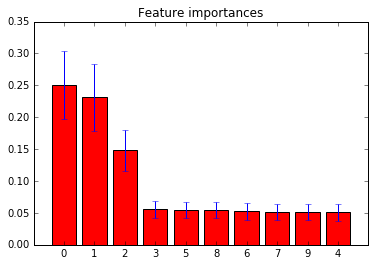

In [70]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


--------------

### 6. IsolationForest example ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

----------------

An example using IsolationForest for anomaly detection.

The IsolationForest 'isolates' observations by randomly selecting a feature
and then randomly selecting a split value between the maximum and minimum
values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the
number of splittings required to isolate a sample is equivalent to the path
length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure
of abnormality and our decision function.

Random partitioning produces noticeable shorter paths for anomalies.
Hence, when a forest of random trees collectively produce shorter path lengths
for particular samples, they are highly likely to be anomalies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


In [2]:
rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))


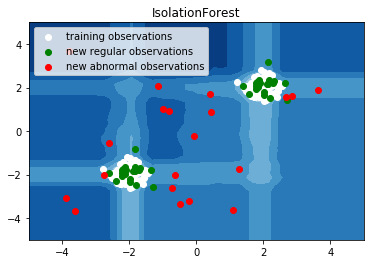

In [3]:

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()


----------

### 7.  Hashing feature transformation using Totally Random Trees ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

-----------

RandomTreesEmbedding provides a way to map data to a
very high-dimensional, sparse representation, which might
be beneficial for classification.
The mapping is completely unsupervised and very efficient.

This example visualizes the partitions given by several
trees and shows how the transformation can also be used for
non-linear dimensionality reduction or non-linear classification.

Points that are neighboring often share the same leaf of a tree and therefore
share large parts of their hashed representation. This allows to
separate two concentric circles simply based on the principal components of the
transformed data.

In high-dimensional spaces, linear classifiers often achieve
excellent accuracy. For sparse binary data, BernoulliNB
is particularly well-suited. The bottom row compares the
decision boundary obtained by BernoulliNB in the transformed
space with an ExtraTreesClassifier forests learned on the
original data.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB


 - Data

In [7]:
# make a synthetic dataset
X, y = make_circles(factor=0.5, random_state=0, noise=0.05)

# use RandomTreesEmbedding to transform data
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X)

 - PCA

In [8]:
# Visualize result using PCA
pca = TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

 - Naive Bayes classifier

In [9]:
# Learn a Naive Bayes classifier on the transformed data
nb = BernoulliNB()
nb.fit(X_transformed, y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

 - ExtraTreesClassifier

In [10]:

# Learn an ExtraTreesClassifier for comparison
trees = ExtraTreesClassifier(max_depth=3, n_estimators=10, random_state=0)
trees.fit(X, y)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=3, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

 - Plot

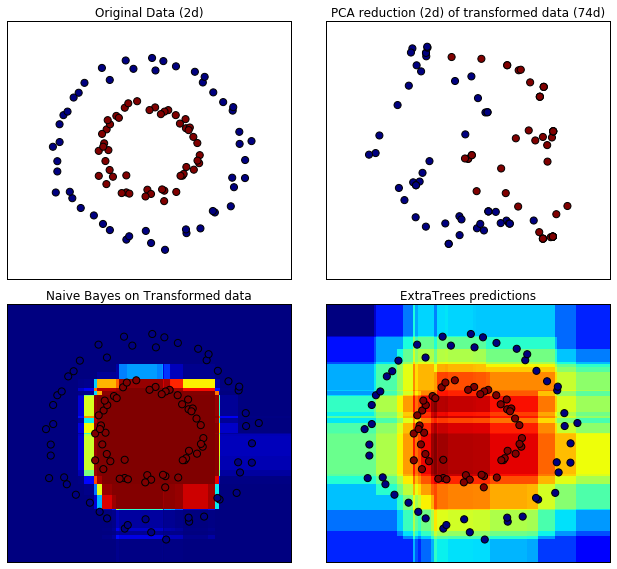

In [11]:
# scatter plot of original and reduced data
fig = plt.figure(figsize=(9, 8))

ax = plt.subplot(221)
ax.scatter(X[:, 0], X[:, 1], c=y, s=50)
ax.set_title("Original Data (2d)")
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(222)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=50)
ax.set_title("PCA reduction (2d) of transformed data (%dd)" %
             X_transformed.shape[1])
ax.set_xticks(())
ax.set_yticks(())

# Plot the decision in original space. For that, we will assign a color to each
# point in the mesh [x_min, m_max] x [y_min, y_max].
h = .01
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# transform grid using RandomTreesEmbedding
transformed_grid = hasher.transform(np.c_[xx.ravel(), yy.ravel()])
y_grid_pred = nb.predict_proba(transformed_grid)[:, 1]

ax = plt.subplot(223)
ax.set_title("Naive Bayes on Transformed data")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50)
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

# transform grid using ExtraTreesClassifier
y_grid_pred = trees.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

ax = plt.subplot(224)
ax.set_title("ExtraTrees predictions")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50)
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

plt.tight_layout()
plt.show()


-------------------

### 8. Two-class AdaBoost ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

--------------------

This example fits an AdaBoosted decision stump on a non-linearly separable
classification dataset composed of two "Gaussian quantiles" clusters
(see :func:`sklearn.datasets.make_gaussian_quantiles`) and plots the decision
boundary and decision scores. The distributions of decision scores are shown
separately for samples of class A and B. The predicted class label for each
sample is determined by the sign of the decision score. Samples with decision
scores greater than zero are classified as B, and are otherwise classified
as A. The magnitude of a decision score determines the degree of likeness with
the predicted class label. Additionally, a new dataset could be constructed
containing a desired purity of class B, for example, by only selecting samples
with a decision score above some value.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

 - Data

In [15]:
# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

 - Model

In [16]:
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=200, random_state=None)

 - Plot

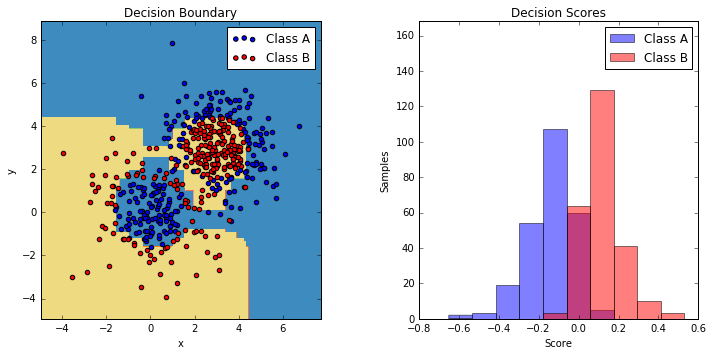

In [17]:
plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5)
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

------------

### 9. Multi-class AdaBoosted Decision Trees ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

---------------

This example reproduces Figure 1 of Zhu et al [1] and shows how boosting can
improve prediction accuracy on a multi-class problem. The classification
dataset is constructed by taking a ten-dimensional standard normal distribution
and defining three classes separated by nested concentric ten-dimensional
spheres such that roughly equal numbers of samples are in each class (quantiles
of the :math:`\chi^2` distribution).

The performance of the SAMME and SAMME.R [1] algorithms are compared. SAMME.R
uses the probability estimates to update the additive model, while SAMME  uses
the classifications only. As the example illustrates, the SAMME.R algorithm
typically converges faster than SAMME, achieving a lower test error with fewer
boosting iterations. The error of each algorithm on the test set after each
boosting iteration is shown on the left, the classification error on the test
set of each tree is shown in the middle, and the boost weight of each tree is
shown on the right. All trees have a weight of one in the SAMME.R algorithm and
therefore are not shown.

In [18]:
from sklearn.externals.six.moves import zip

import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

 - Data

In [19]:
X, y = make_gaussian_quantiles(n_samples=13000, n_features=10,
                               n_classes=3, random_state=1)

n_split = 3000

X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]

 - Model

In [20]:
bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

 - Plot

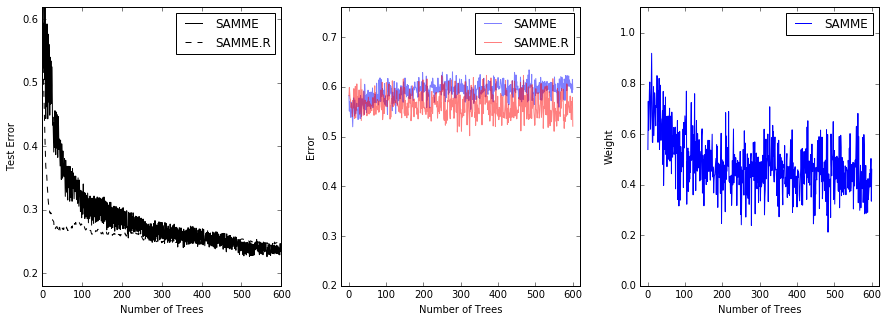

In [21]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1),
         discrete_test_errors, c='black', label='SAMME')
plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='black',
         linestyle='dashed', label='SAMME.R')
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='SAMME', alpha=.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
         "r", label='SAMME.R', alpha=.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
         "b", label='SAMME')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()


----------------------

### 10 .Discrete versus Real AdaBoost ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

-------------------------

This example is based on Figure 10.2 from Hastie et al 2009 [1] and illustrates
the difference in performance between the discrete SAMME [2] boosting
algorithm and real SAMME.R boosting algorithm. Both algorithms are evaluated
on a binary classification task where the target Y is a non-linear function
of 10 input features.

Discrete SAMME AdaBoost adapts based on errors in predicted class labels
whereas real SAMME.R uses the predicted class probabilities.


In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier

 - Data

In [23]:
n_estimators = 400
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.

X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)

X_test, y_test = X[2000:], y[2000:]
X_train, y_train = X[:2000], y[:2000]

 - Model

In [24]:
dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")
ada_real.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=400, random_state=None)

 - Plot

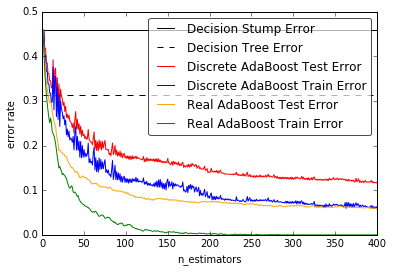

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')
ax.plot(np.arange(n_estimators) + 1, ada_real_err,
        label='Real AdaBoost Test Error',
        color='orange')
ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
        label='Real AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

----------------

### 11. Decision Tree Regression with AdaBoost ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

----------------

A decision tree is boosted using the AdaBoost.R2 [1] algorithm on a 1D
sinusoidal dataset with a small amount of Gaussian noise.
299 boosts (300 decision trees) is compared with a single decision tree
regressor. As the number of boosts is increased the regressor can fit more
detail.

In [26]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

 - Data

In [27]:
# Create the dataset
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

 - Model

In [28]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=<mtrand.RandomState object at 0x114302d90>)

 - Predict

In [29]:
# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

 - Plot

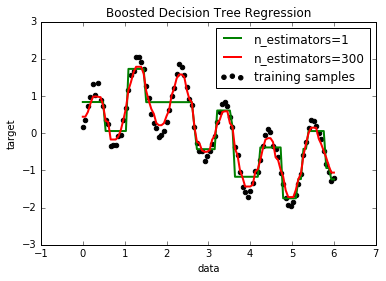

In [30]:
# Plot the results
plt.figure()
plt.scatter(X, y, c="k", label="training samples")
plt.plot(X, y_1, c="g", label="n_estimators=1", linewidth=2)
plt.plot(X, y_2, c="r", label="n_estimators=300", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()


-----------------------

### 12. Gradient Boosting Out-of-Bag estimates ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

----------------------


Out-of-bag (OOB) estimates can be a useful heuristic to estimate
the "optimal" number of boosting iterations.
OOB estimates are almost identical to cross-validation estimates but
they can be computed on-the-fly without the need for repeated model
fitting.
OOB estimates are only available for Stochastic Gradient Boosting
(i.e. ``subsample < 1.0``), the estimates are derived from the improvement
in loss based on the examples not included in the bootstrap sample
(the so-called out-of-bag examples).
The OOB estimator is a pessimistic estimator of the true
test loss, but remains a fairly good approximation for a small number of trees.

The figure shows the cumulative sum of the negative OOB improvements
as a function of the boosting iteration. As you can see, it tracks the test
loss for the first hundred iterations but then diverges in a
pessimistic way.
The figure also shows the performance of 3-fold cross validation which
usually gives a better estimate of the test loss
but is computationally more demanding.



In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split

/home/bitnami/anaconda3/envs/caseolap/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


 - Data

In [5]:
# Generate data (adapted from G. Ridgeway's gbm example)
n_samples = 1000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)

p = 1 / (1.0 + np.exp(-(np.sin(3 * x1) - 4 * x2 + x3)))
y = random_state.binomial(1, p, size=n_samples)

X = np.c_[x1, x2, x3]

X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=9)

 - Model

In [6]:
# Fit classifier with out-of-bag estimates
params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))

n_estimators = params['n_estimators']
x = np.arange(n_estimators) + 1


def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score


def cv_estimate(n_folds=3):
    cv = KFold(n_folds=n_folds)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        cv_clf.fit(X_train[train], y_train[train])
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_folds
    return val_scores


# Estimate best n_estimator using cross-validation
cv_score = cv_estimate(3)

# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)

# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]


Accuracy: 0.6840


TypeError: __init__() missing 1 required positional argument: 'n'

 - Plot

In [7]:

# color brew for the three curves
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# plot curves and vertical lines for best iterations
plt.plot(x, cumsum, label='OOB loss', color=oob_color)
plt.plot(x, test_score, label='Test loss', color=test_color)
plt.plot(x, cv_score, label='CV loss', color=cv_color)
plt.axvline(x=oob_best_iter, color=oob_color)
plt.axvline(x=test_best_iter, color=test_color)
plt.axvline(x=cv_best_iter, color=cv_color)

# add three vertical lines to xticks
xticks = plt.xticks()
xticks_pos = np.array(xticks[0].tolist() +
                      [oob_best_iter, cv_best_iter, test_best_iter])
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) +
                        ['OOB', 'CV', 'Test'])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label)

plt.legend(loc='upper right')
plt.ylabel('normalized loss')
plt.xlabel('number of iterations')

plt.show()

NameError: name 'cumsum' is not defined

--------------

### 13. Prediction Intervals for Gradient Boosting Regression ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

----------------


This example shows how quantile regression can be used
to create prediction intervals.



In [37]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor


 - Data

In [38]:

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

alpha = 0.95

 - Model

In [39]:
clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_upper = clf.predict(xx)

clf.set_params(alpha=1.0 - alpha)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_lower = clf.predict(xx)

clf.set_params(loss='ls')
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)

 - Plot

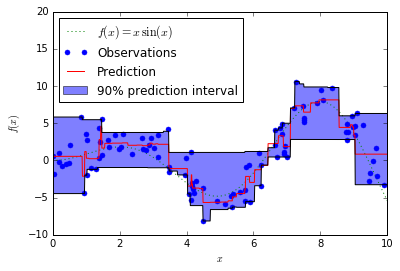

In [40]:
# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()


--------------------------

### 14. Gradient Boosting regression ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

-------------------------

Demonstrate Gradient Boosting on the Boston housing dataset.

This example fits a Gradient Boosting model with least squares loss and
500 regression trees of depth 4.

In [42]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

 - Data

In [43]:

# Load data
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

 - Model

In [44]:
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 6.6213


 - Plot training deviance

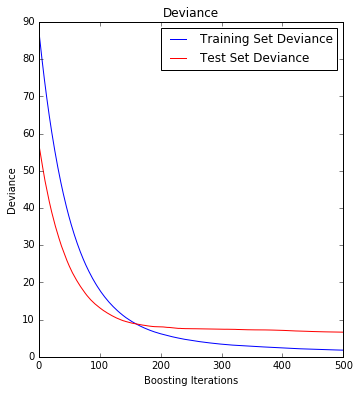

In [47]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

 - Plot

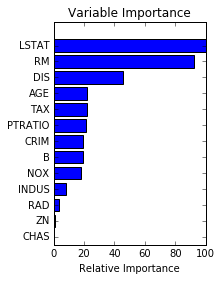

In [48]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


-------------

### 15. Gradient Boosting regularization ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

-------------

Illustration of the effect of different regularization strategies
for Gradient Boosting. The example is taken from Hastie et al 2009.

The loss function used is binomial deviance. Regularization via
shrinkage (``learning_rate < 1.0``) improves performance considerably.
In combination with shrinkage, stochastic gradient boosting
(``subsample < 1.0``) can produce more accurate models by reducing the
variance via bagging.
Subsampling without shrinkage usually does poorly.
Another strategy to reduce the variance is by subsampling the features
analogous to the random splits in Random Forests
(via the ``max_features`` parameter).



In [50]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets

 - Data

In [51]:

X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)
X = X.astype(np.float32)

# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}



 - Plot n  Model

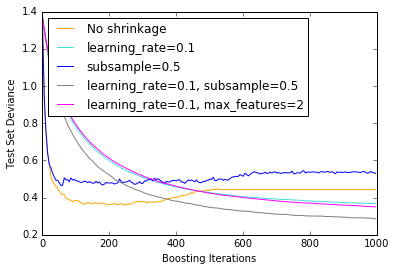

In [52]:
plt.figure()

for label, color, setting in [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('subsample=0.5', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.5}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2})]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()


-----------

### 16. Partial Dependence Plots ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

-------------


Partial dependence plots show the dependence between the target function [2]_
and a set of 'target' features, marginalizing over the
values of all other features (the complement features). Due to the limits
of human perception the size of the target feature set must be small (usually,
one or two) thus the target features are usually chosen among the most
important features
(see :attr:`~sklearn.ensemble.GradientBoostingRegressor.feature_importances_`).

This example shows how to obtain partial dependence plots from a
:class:`~sklearn.ensemble.GradientBoostingRegressor` trained on the California
housing dataset. The example is taken from [1]_.

The plot shows four one-way and one two-way partial dependence plots.
The target variables for the one-way PDP are:
median income (`MedInc`), avg. occupants per household (`AvgOccup`),
median house age (`HouseAge`), and avg. rooms per household (`AveRooms`).

We can clearly see that the median house price shows a linear relationship
with the median income (top left) and that the house price drops when the
avg. occupants per household increases (top middle).
The top right plot shows that the house age in a district does not have
a strong influence on the (median) house price; so does the average rooms
per household.
The tick marks on the x-axis represent the deciles of the feature values
in the training data.

Partial dependence plots with two target features enable us to visualize
interactions among them. The two-way partial dependence plot shows the
dependence of median house price on joint values of house age and avg.
occupants per household. We can clearly see an interaction between the
two features:
For an avg. occupancy greater than two, the house price is nearly independent
of the house age, whereas for values less than two there is a strong dependence
on age.

In [8]:
from __future__ import print_function


import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.datasets.california_housing import fetch_california_housing

 - Alltogether

Training GBRT... done.
Convenience plot with ``partial_dependence_plots``
Custom 3d plot via ``partial_dependence``


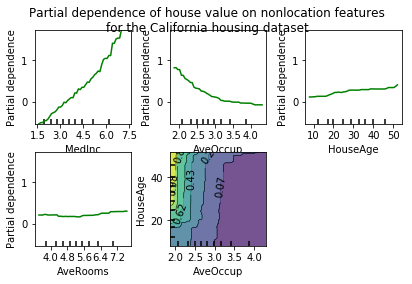

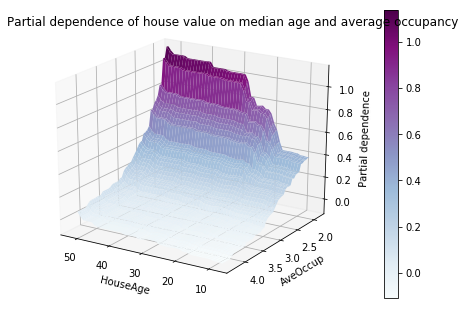

In [9]:
def main():
    cal_housing = fetch_california_housing()

    # split 80/20 train-test
    X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                        cal_housing.target,
                                                        test_size=0.2,
                                                        random_state=1)
    names = cal_housing.feature_names

    print("Training GBRT...", flush=True, end='')
    clf = GradientBoostingRegressor(n_estimators=100, max_depth=4,
                                    learning_rate=0.1, loss='huber',
                                    random_state=1)
    clf.fit(X_train, y_train)
    print(" done.")

    print('Convenience plot with ``partial_dependence_plots``')

    features = [0, 5, 1, 2, (5, 1)]
    fig, axs = plot_partial_dependence(clf, X_train, features,
                                       feature_names=names,
                                       n_jobs=3, grid_resolution=50)
    fig.suptitle('Partial dependence of house value on nonlocation features\n'
                 'for the California housing dataset')
    plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

    print('Custom 3d plot via ``partial_dependence``')
    fig = plt.figure()

    target_feature = (1, 5)
    pdp, axes = partial_dependence(clf, target_feature,
                                   X=X_train, grid_resolution=50)
    XX, YY = np.meshgrid(axes[0], axes[1])
    Z = pdp[0].reshape(list(map(np.size, axes))).T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
    ax.set_xlabel(names[target_feature[0]])
    ax.set_ylabel(names[target_feature[1]])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence of house value on median age and '
                 'average occupancy')
    plt.subplots_adjust(top=0.9)

    plt.show()


# Needed on Windows because plot_partial_dependence uses multiprocessing
if __name__ == '__main__':
    main()


--------------

### 17. Plot the decision boundaries of a VotingClassifier ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

---------------


Plot the decision boundaries of a `VotingClassifier` for
two features of the Iris dataset.

Plot the class probabilities of the first sample in a toy dataset
predicted by three different classifiers and averaged by the
`VotingClassifier`.

First, three exemplary classifiers are initialized (`DecisionTreeClassifier`,
`KNeighborsClassifier`, and `SVC`) and used to initialize a
soft-voting `VotingClassifier` with weights `[2, 1, 2]`, which means that
the predicted probabilities of the `DecisionTreeClassifier` and `SVC`
count 5 times as much as the weights of the `KNeighborsClassifier` classifier
when the averaged probability is calculated.


In [56]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

 - Data

In [57]:
# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

- Model

In [58]:
# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')), ('knn', ...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         voting='soft', weights=[2, 1, 2])

 - Plot

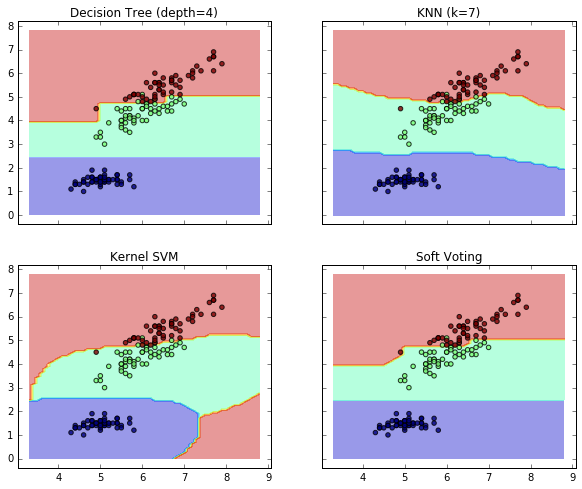

In [59]:
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()


-----------------

### 18. Plot class probabilities calculated by the VotingClassifier ([source](https://github.com/scikit-learn/scikit-learn/tree/master/examples/ensemble))

-------------------


Plot the class probabilities of the first sample in a toy dataset
predicted by three different classifiers and averaged by the
`VotingClassifier`.

First, three examplary classifiers are initialized (`LogisticRegression`,
`GaussianNB`, and `RandomForestClassifier`) and used to initialize a
soft-voting `VotingClassifier` with weights `[1, 1, 5]`, which means that
the predicted probabilities of the `RandomForestClassifier` count 5 times
as much as the weights of the other classifiers when the averaged probability
is calculated.

To visualize the probability weighting, we fit each classifier on the training
set and plot the predicted class probabilities for the first sample in this
example dataset.


In [61]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

 - Model 

In [62]:
clf1 = LogisticRegression(random_state=123)
clf2 = RandomForestClassifier(random_state=123)
clf3 = GaussianNB()
X = np.array([[-1.0, -1.0], [-1.2, -1.4], [-3.4, -2.2], [1.1, 1.2]])
y = np.array([1, 1, 2, 2])

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                        voting='soft',
                        weights=[1, 1, 5])



 - Predict 

In [63]:
# predict class probabilities for all classifiers
probas = [c.fit(X, y).predict_proba(X) for c in (clf1, clf2, clf3, eclf)]

# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

 - Plot

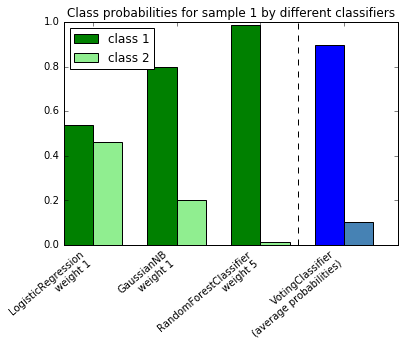

In [64]:
# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width, color='green')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width, color='lightgreen')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width, color='blue')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width, color='steelblue')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['LogisticRegression\nweight 1',
                    'GaussianNB\nweight 1',
                    'RandomForestClassifier\nweight 5',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.show()
